In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.optimize import minimize

mpl.rc('font', family = 'Gulim')
mpl.rcParams['axes.unicode_minus']=False

In [2]:
a = pd.read_csv("Project_week.csv", encoding = "euc-kr")

In [3]:
a

,주차,총확진,서울확진,부산확진,대구확진,인천확진,광주확진,대전확진,울산확진,세종확진,...,세종사망,경기사망,강원사망,충북사망,충남사망,전북사망,전남사망,경북사망,경남사망,제주사망
0,1,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,11,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,13,4,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,733,16,17,439,1,7,3,1,1,...,0,0,0,0,0,0,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,177,115063,25289,9459,5268,5930,3584,3023,2779,825,...,0,12,8,3,1,6,2,4,3,0
177,178,113854,23955,10335,5106,5852,3883,2662,2970,879,...,0,7,3,0,4,4,3,4,3,5
178,179,113141,23612,10291,5523,6057,3725,2907,2763,832,...,0,8,1,0,3,3,3,4,3,7
179,180,124543,25852,11679,5948,6608,3921,3232,3124,706,...,0,10,3,2,2,2,4,3,7,1


# 인구

In [4]:
# 총인구
b = pd.read_csv("Projecti_population.csv", encoding = "euc-kr")

b = b.transpose()
b.columns = ["전국","서울","부산","대구","인천","광주","대전","울산","세종","경기","강원","충북","충남",
            "전북","전남","경북","경남","제주"]
b =b.iloc[1:]
b = b.astype(int)
b = (b/10000).astype(int)

b_des = b.describe()

population = b_des.iloc[5].astype(int)
population = population * 10000

In [5]:
population

전국    51660000
서울     9530000
부산     3350000
대구     2390000
인천     2950000
광주     1440000
대전     1450000
울산     1120000
세종      360000
경기    13540000
강원     1530000
충북     1590000
충남     2110000
전북     1780000
전남     1830000
경북     2620000
경남     3310000
제주      670000
Name: 50%, dtype: int32

# 전국

In [13]:
# 데이터 추출
a1 = a.iloc[:,[0,1,19]]

In [14]:
a1

,주차,총확진,총사망
0,1,3,0
1,2,11,0
2,3,13,0
3,4,2,0
4,5,733,7
...,...,...,...
176,177,115063,66
177,178,113854,67
178,179,113141,57
179,180,124543,54


In [15]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_12712\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_12712\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_12712\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [16]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["전국"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

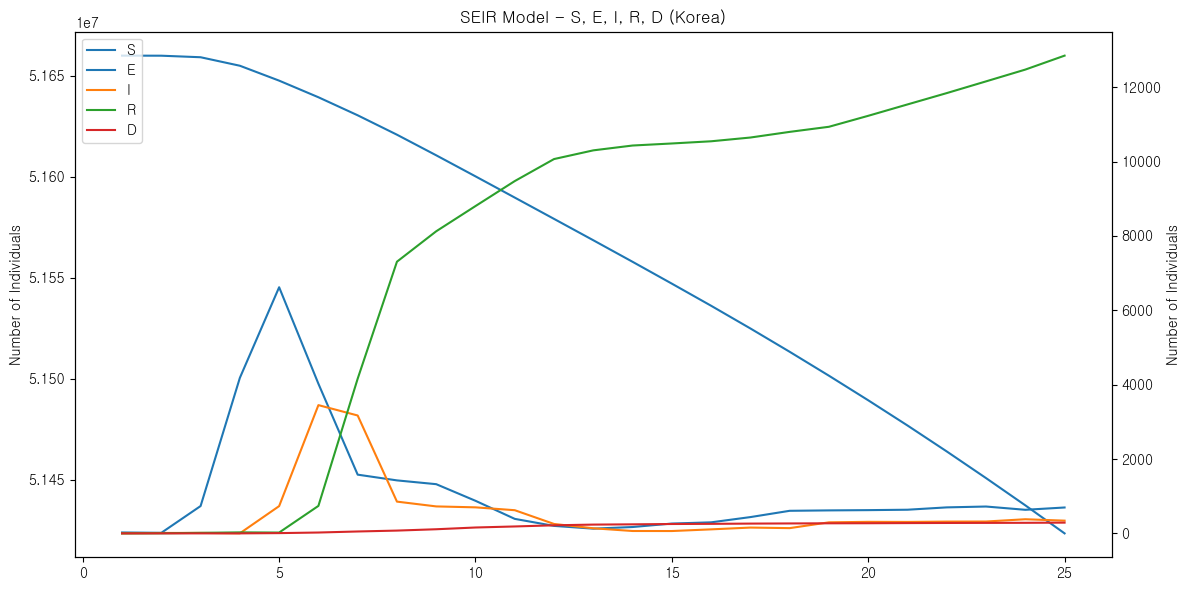

In [17]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Korea)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [18]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)


# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [2.31550896e+02 2.67234831e+01 2.30028652e-02]


# 서울

In [10]:
# 데이터 추출
a1 = a.iloc[:,[0,2,20]]

In [11]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [12]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["서울"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

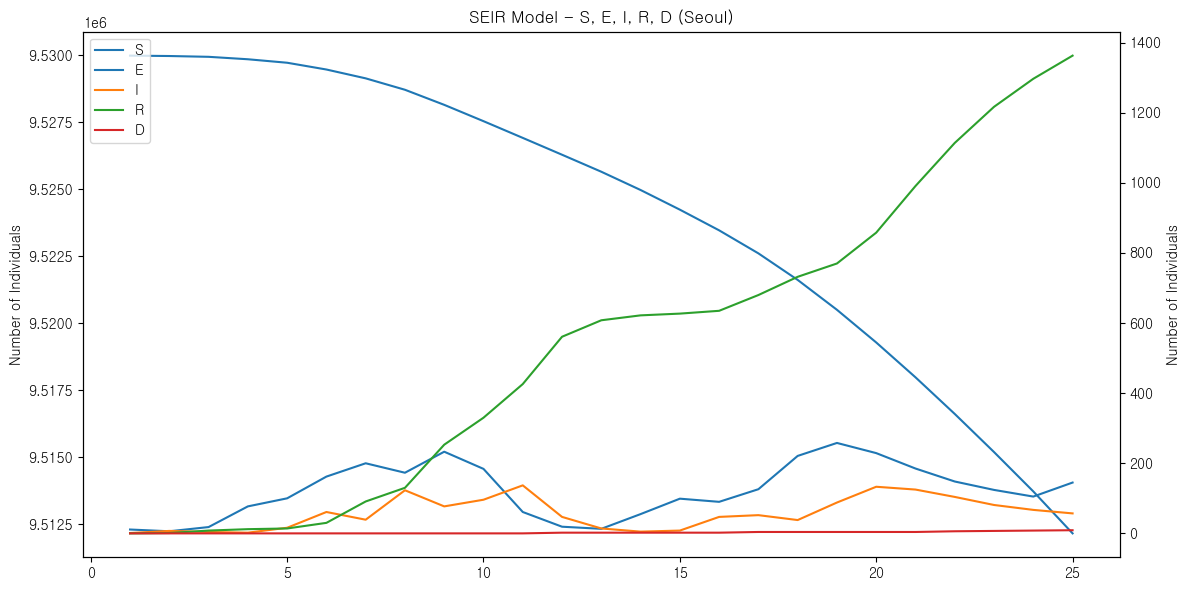

In [13]:
data = a1.iloc[:25]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Seoul)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [14]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [2.47204676e+02 4.11607209e+00 4.89931285e-03]


# 부산

In [15]:
# 데이터 추출
a1 = a.iloc[:,[0,3,21]]

In [16]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [17]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["부산"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

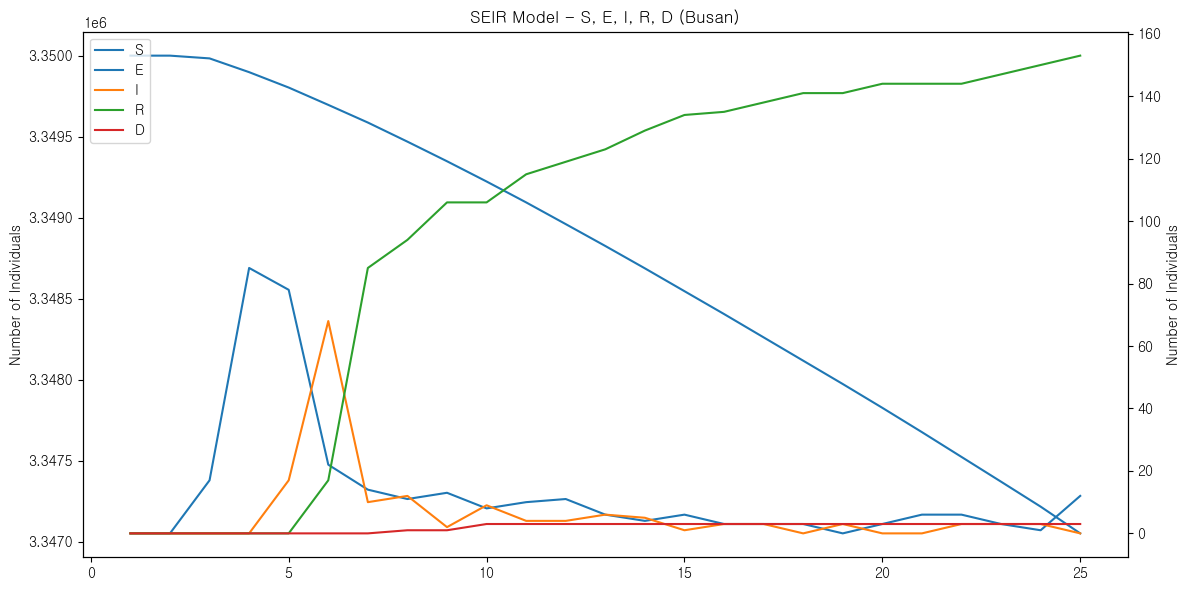

In [18]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Busan)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [19]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [0.1 0.1 0.1]


# 대구

In [20]:
# 데이터 추출
a1 = a.iloc[:,[0,4,22]]

In [21]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [22]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["대구"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

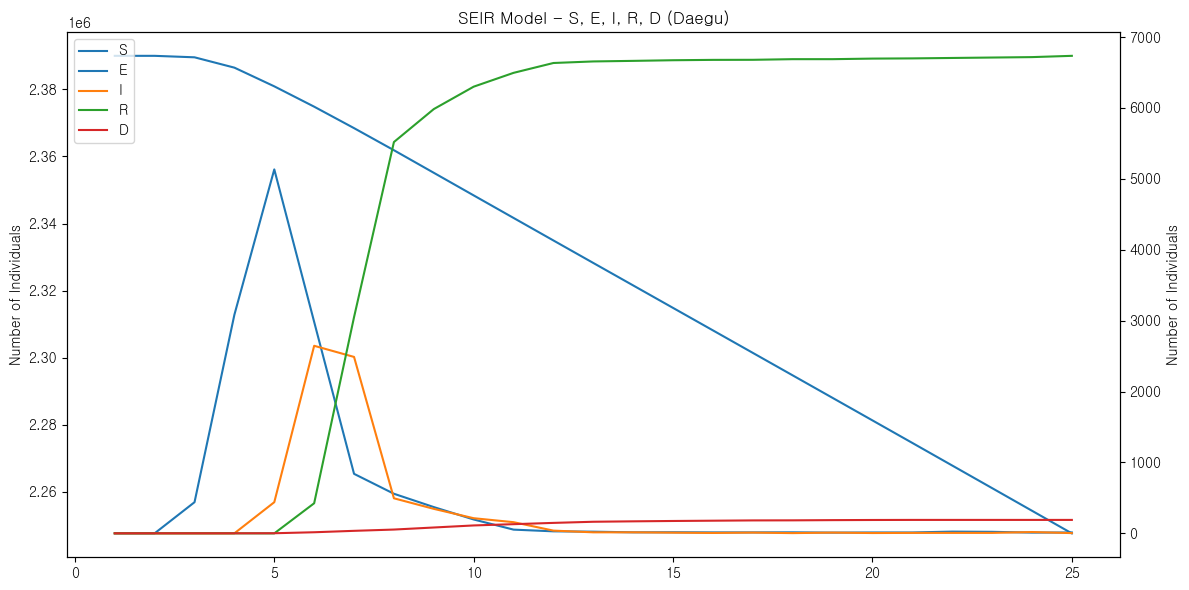

In [23]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Daegu)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [24]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [0.1 0.1 0.1]


# 인천

In [25]:
# 데이터 추출
a1 = a.iloc[:,[0,5,23]]

In [26]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [27]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["인천"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

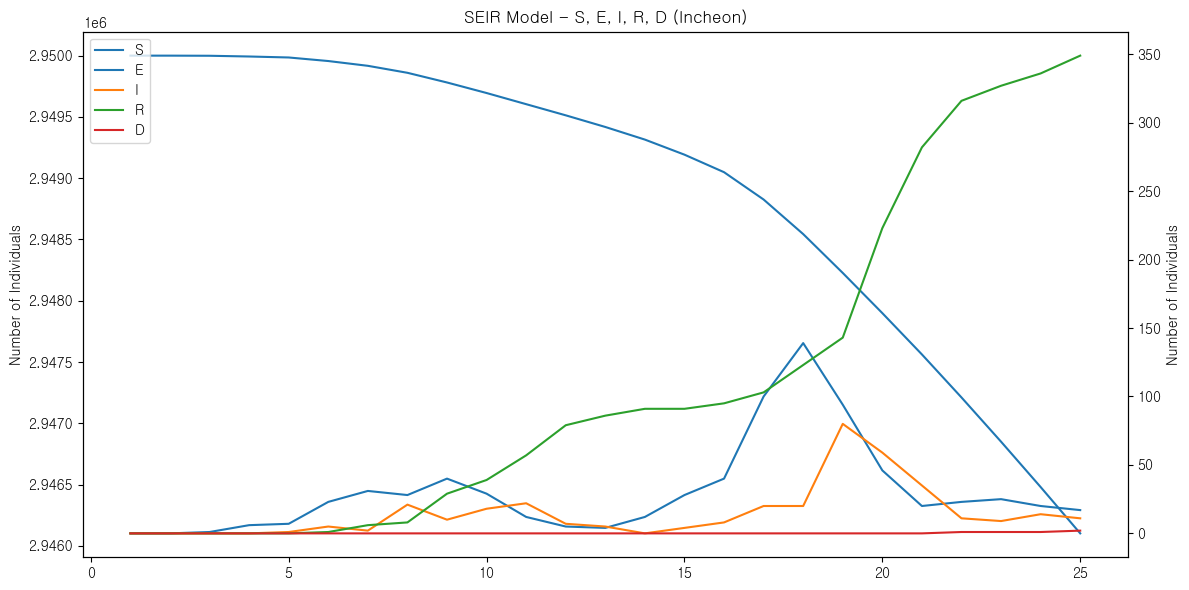

In [28]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Incheon)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [29]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [0.1 0.1 0.1]


# 광주

In [30]:
# 데이터 추출
a1 = a.iloc[:,[0,6,24]]

In [31]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [32]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["광주"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

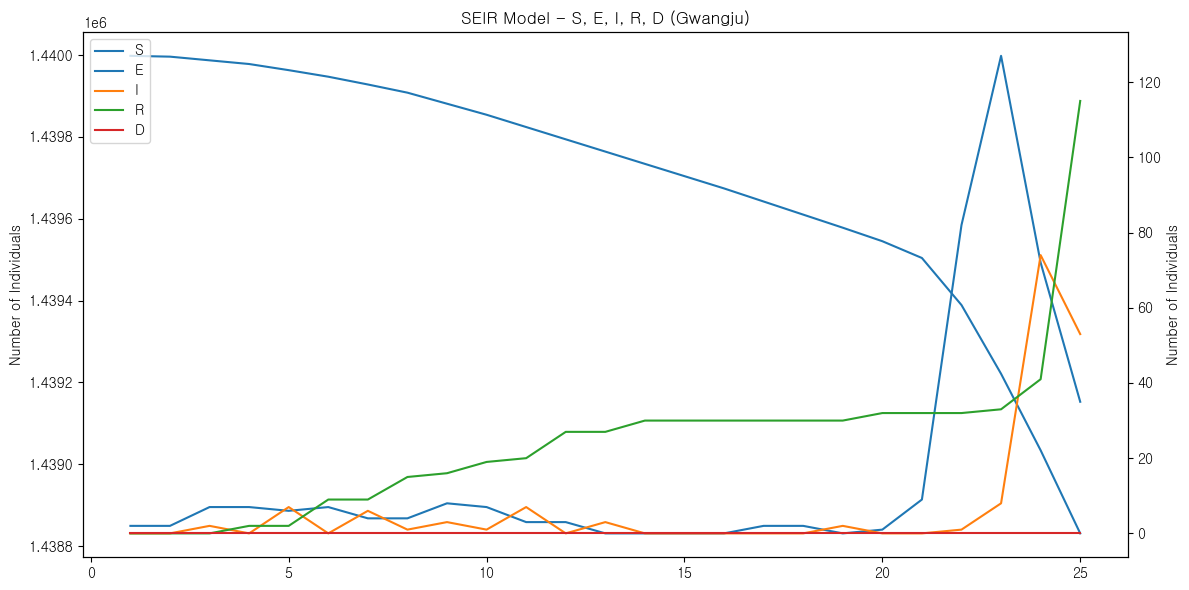

In [33]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Gwangju)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [34]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [6.26773812e+06 1.06909775e+00 4.23261399e-06]


# 대전

In [35]:
# 데이터 추출
a1 = a.iloc[:,[0,7,25]]

In [36]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [37]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["대전"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

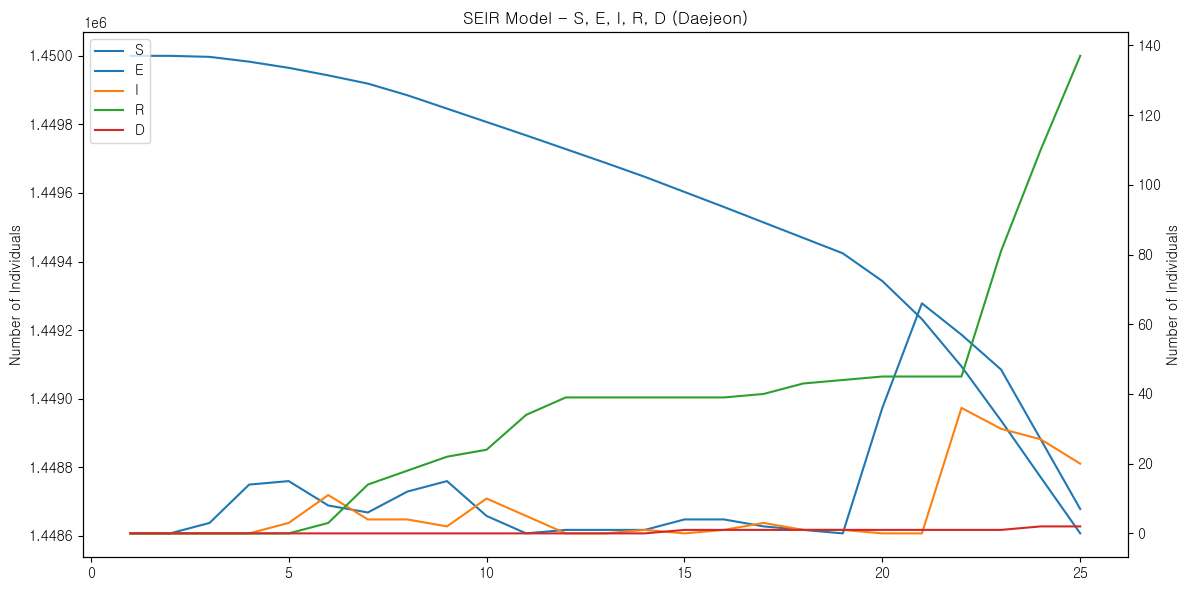

In [38]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Daejeon)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [39]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [0.1 0.1 0.1]


# 울산

In [40]:
# 데이터 추출
a1 = a.iloc[:,[0,8,26]]

In [41]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [42]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["울산"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

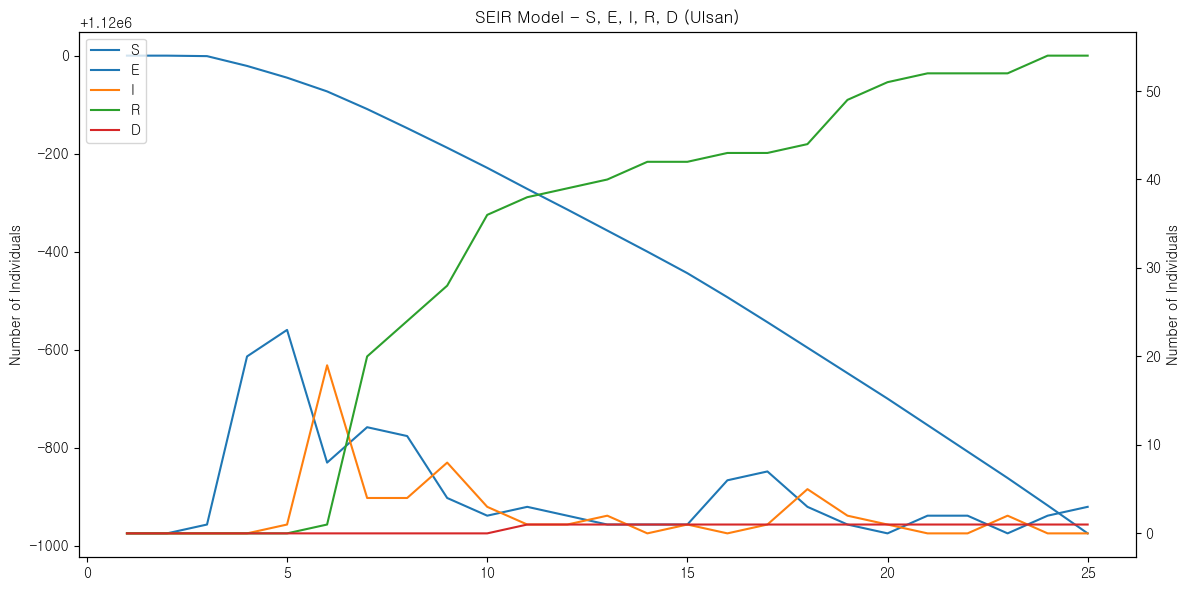

In [43]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Ulsan)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [44]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [0.1 0.1 0.1]


# 세종

In [45]:
# 데이터 추출
a1 = a.iloc[:,[0,9,27]]

In [46]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [47]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["세종"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

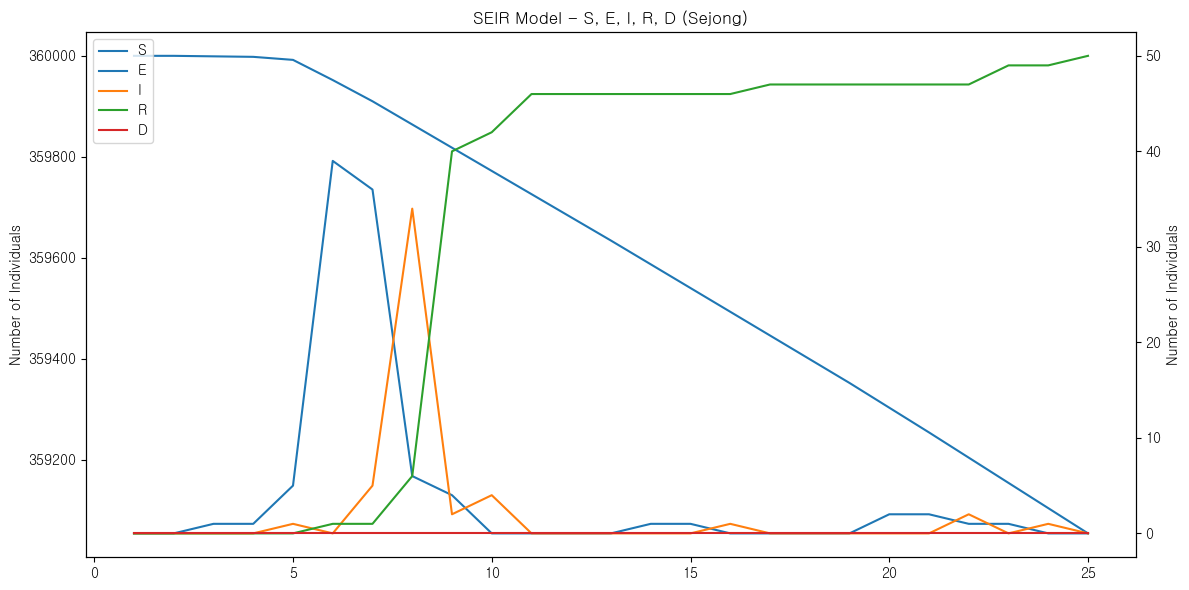

In [48]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Sejong)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [49]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [0.1 0.1 0.1]


# 경기

In [50]:
# 데이터 추출
a1 = a.iloc[:,[0,10,28]]

In [51]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [52]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["경기"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

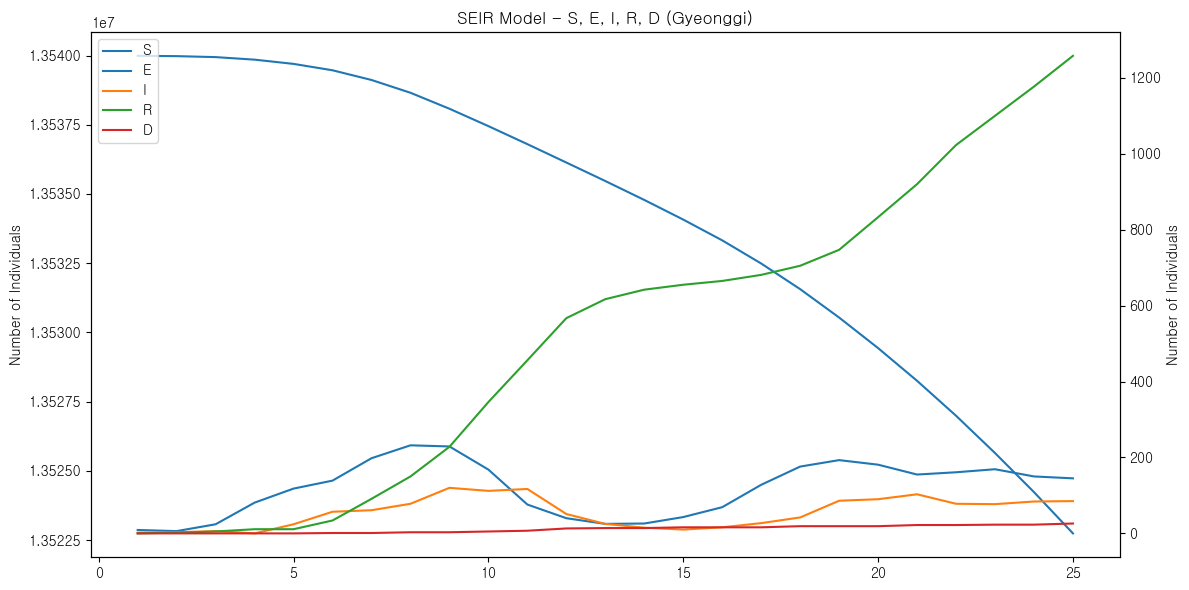

In [53]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Gyeonggi)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [54]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [6.77356238e+01 4.57576360e+00 2.18050093e-02]


# 강원

In [55]:
# 데이터 추출
a1 = a.iloc[:,[0,11,29]]

In [56]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [57]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["강원"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

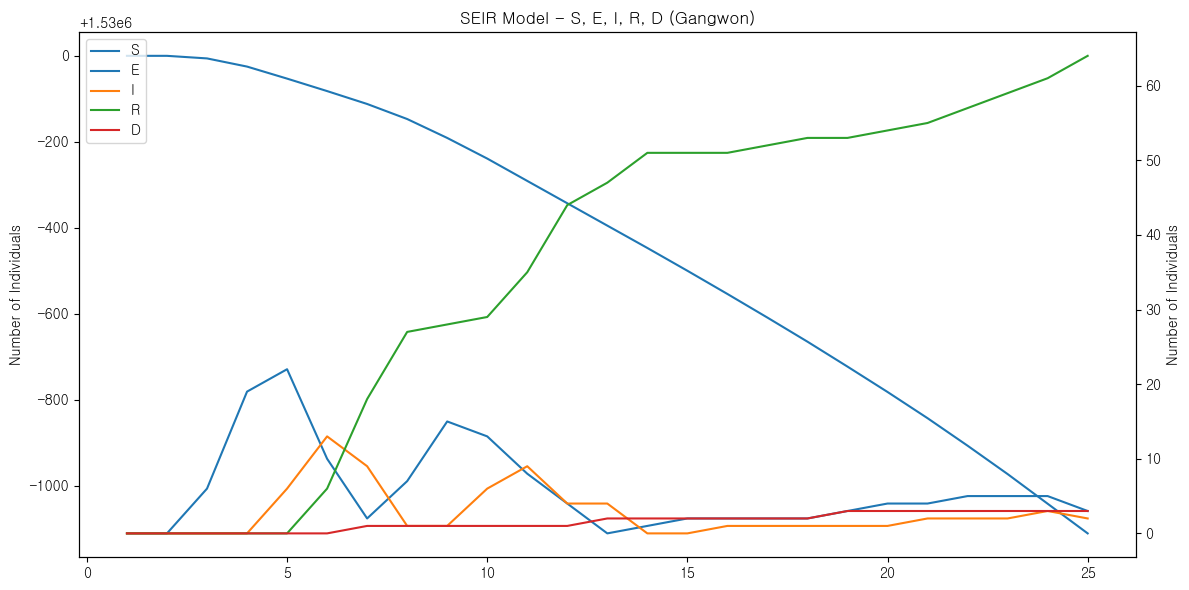

In [58]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Gangwon)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [59]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [0.1 0.1 0.1]


# 충북

In [60]:
# 데이터 추출
a1 = a.iloc[:,[0,12,30]]

In [61]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [62]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["충북"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

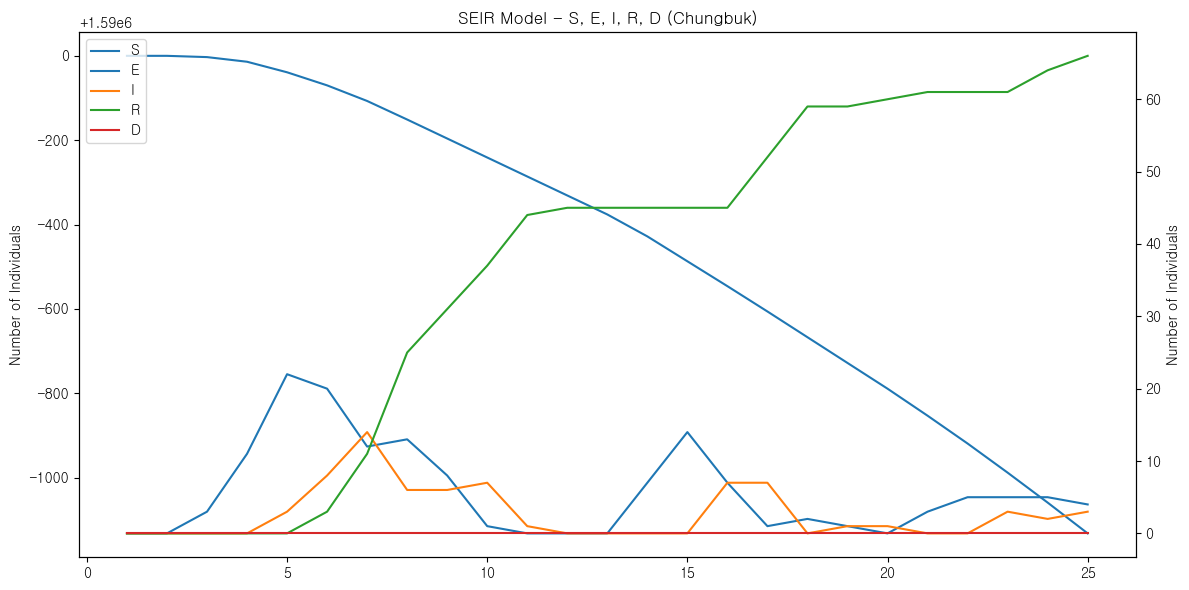

In [63]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Chungbuk)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [64]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [0.1 0.1 0.1]


# 충남

In [65]:
# 데이터 추출
a1 = a.iloc[:,[0,13,31]]

In [66]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [67]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["충남"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

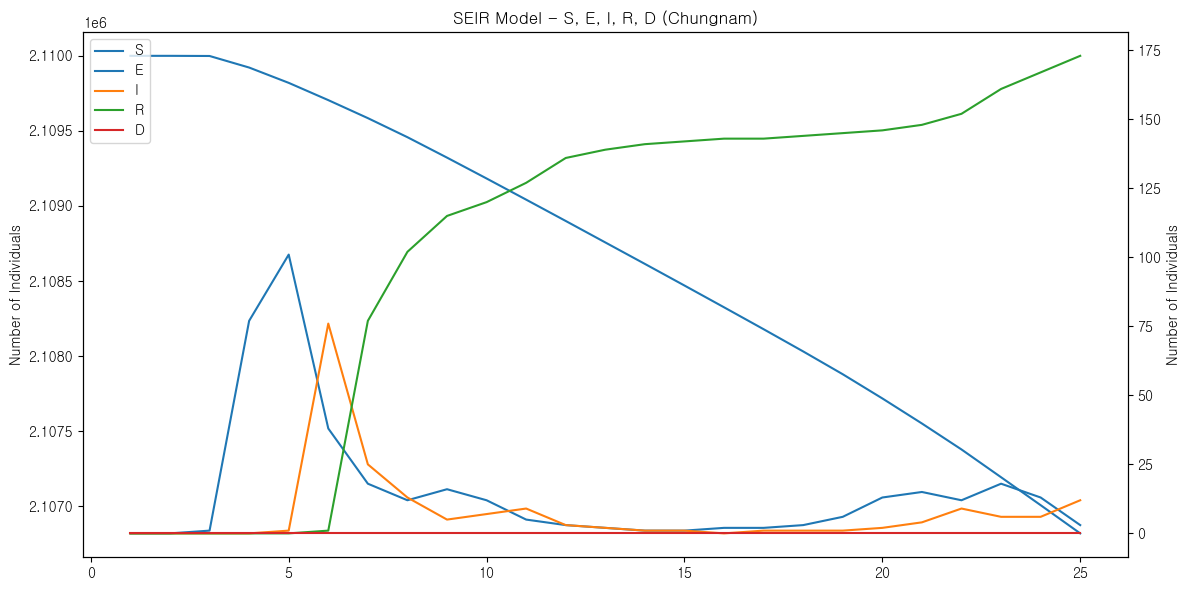

In [68]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Chungnam)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [69]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [0.1 0.1 0.1]


# 전북

In [70]:
# 데이터 추출
a1 = a.iloc[:,[0,14,32]]

In [71]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [72]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["전북"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

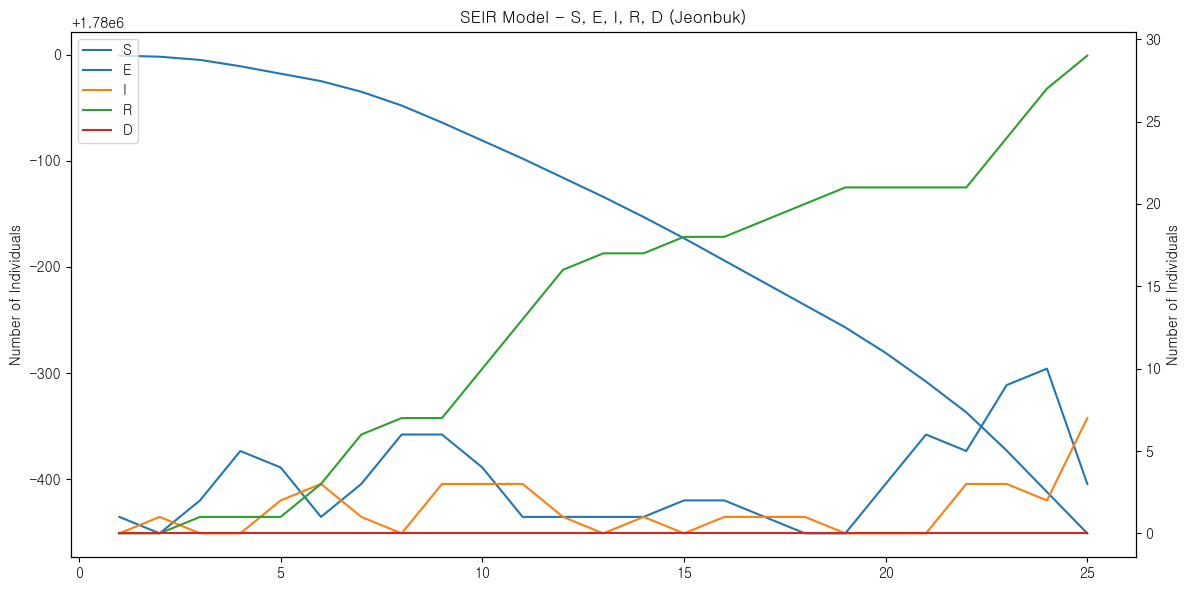

In [73]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Jeonbuk)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [74]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [ 6.82525552e+01  1.16906401e+00 -4.07874865e-04]


# 전남

In [75]:
# 데이터 추출
a1 = a.iloc[:,[0,15,33]]

In [76]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [77]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["전남"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

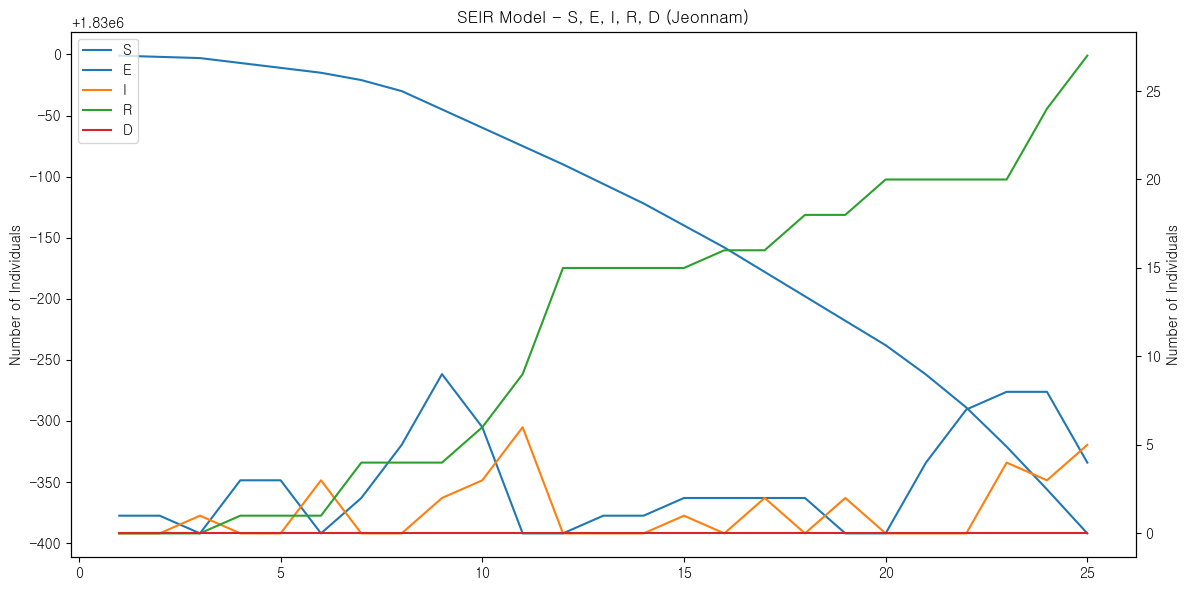

In [78]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Jeonnam)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [79]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [ 4.07296600e+00  1.36547569e+00 -3.31171001e-04]


# 경북

In [80]:
# 데이터 추출
a1 = a.iloc[:,[0,16,34]]

In [81]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [82]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["경북"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

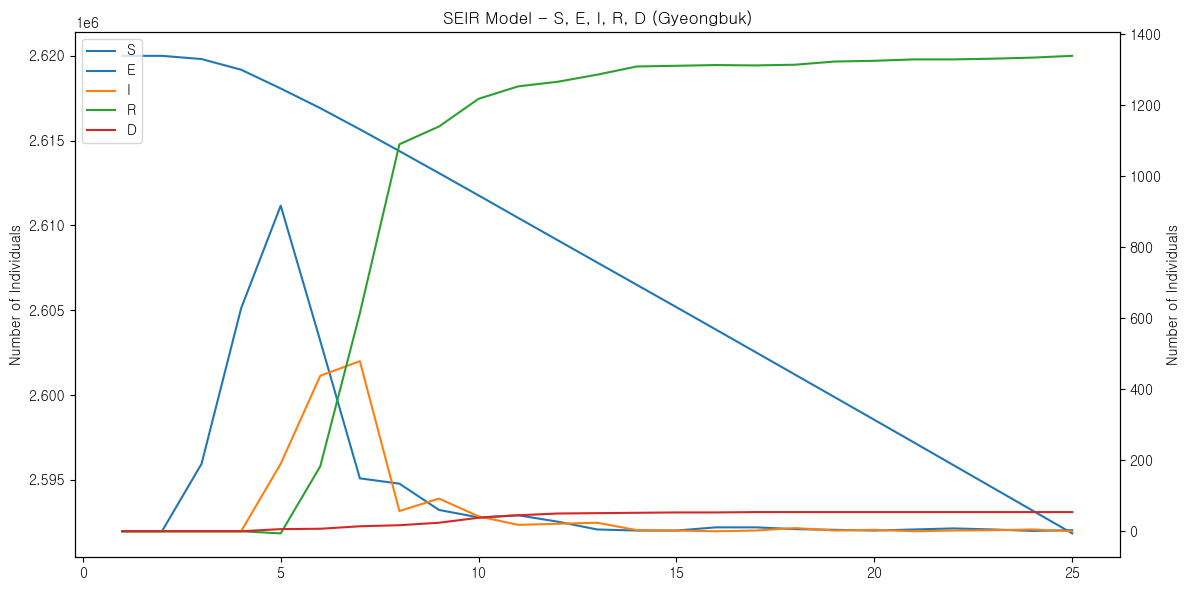

In [83]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Gyeongbuk)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [84]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [0.1 0.1 0.1]


# 경남

In [85]:
# 데이터 추출
a1 = a.iloc[:,[0,17,35]]

In [86]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [87]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["경남"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

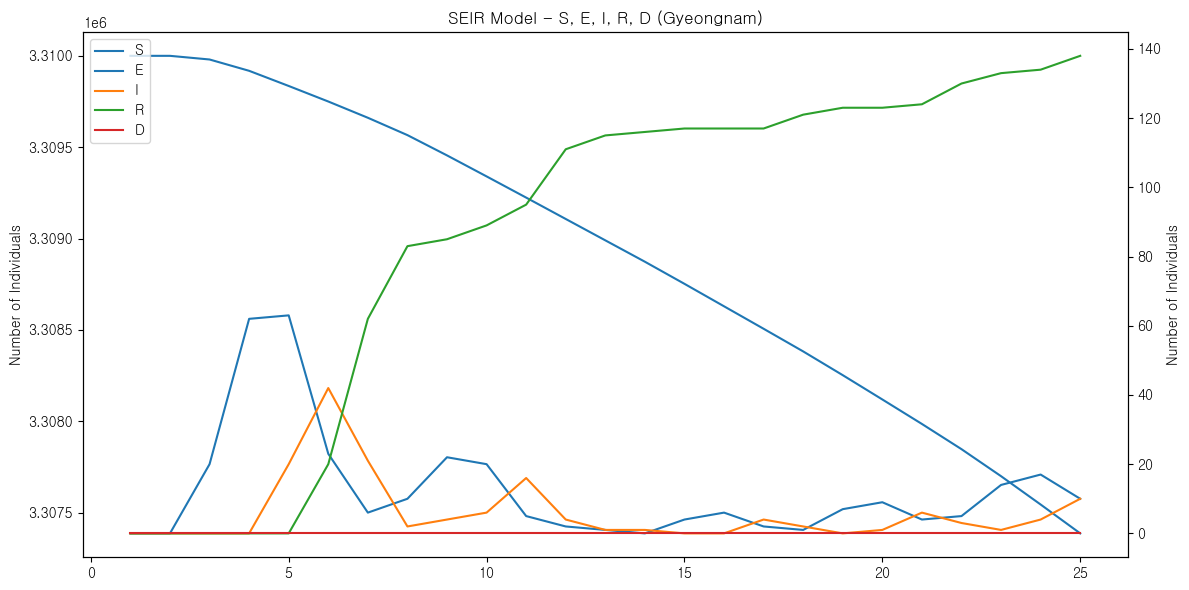

In [88]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Gyeongnam)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [89]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [0.1 0.1 0.1]


# 제주

In [90]:
# 데이터 추출
a1 = a.iloc[:,[0,18,36]]

In [91]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_3792\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [92]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["제주"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()  

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

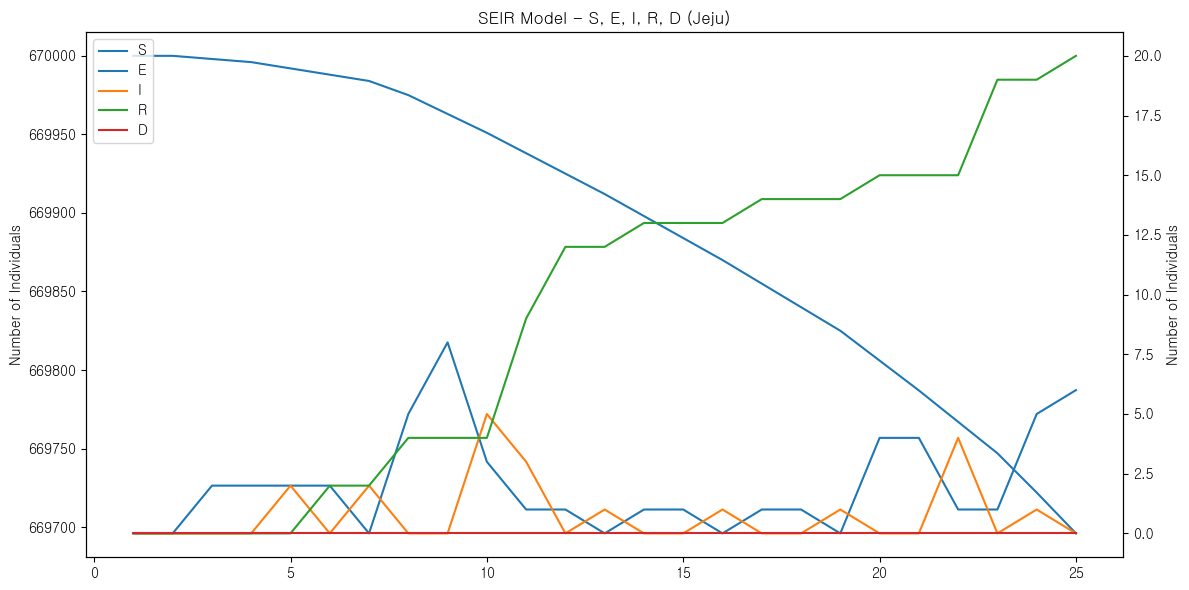

In [93]:
data = a1.iloc[:25]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Jeju)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [94]:
data = data.iloc[:,[0,2,3,4,5]]

# 주어진 ODEs
def model(y, t, alpha, gamma, mu):
    E, I, R, D = y
    dEdt = -alpha * E + gamma * I
    dIdt = alpha * E - gamma * I
    dRdt = gamma * (1 - mu) * I
    dDdt = gamma * mu * I
    return [dEdt, dIdt, dRdt, dDdt]

# 오차 함수
def loss(params, data, times):
    alpha, gamma, mu = params
    y0 = data.iloc[0, 1:5].values
    ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
    diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
    return np.sum(diff**2)

# 시간 값
times = data['week']

# 초기 추정값
initial_alpha = 0.1
initial_gamma = 0.1
initial_mu = 0.1
initial_params = [initial_alpha, initial_gamma, initial_mu]

# 최적화 수행
result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

# 추정된 파라미터
estimated_params = result.x
print("Estimated Parameters:", estimated_params)


Estimated Parameters: [0.1 0.1 0.1]
